In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| default_exp data

# Data

> A simple API for importing and preparing data for use. Mostly manipulates numpy arrays to generate profiles and sections
> as well as plane levelling, noise removal and waviness removal/separation. 

In [ ]:
#|hide
from nbdev.showdoc import *


In [ ]:
#note
#Generate a gausspulse for testing?

In [ ]:
#| export
import numpy as np
import imutils
import cv2 as cv
from matplotlib import pyplot as plt
import scipy.ndimage as ndimage
import scipy
import sklearn.preprocessing
import sklearn.linear_model
from mpl_toolkits import mplot3d

In [ ]:
#| hide
from fastcore.test import *

We will be treating 2D arrays as rasters. Basically load any .csv, .txt or other file into a numpy  array as you would normally. Each entry should be the height data for it's respective pixel. 

Let's try out the simplest method, a text file containing an (M,N) array compatible with Numpy.
If you'd like to try your own data, simply change the file below and the loading function (e.g. if you have a .csv just change the delimeter in the np.loadtxt() call).

In [ ]:
file = 'BYGS008_top_segment_500samp_10cm_interp089.txt'
image = np.loadtxt(file)

Let's have a look at the image 

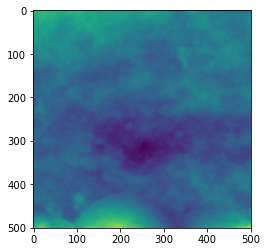

In [ ]:
plt.imshow(image)
plt.show()

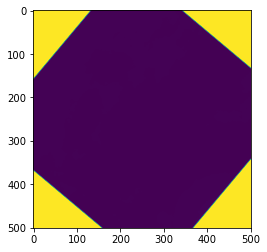

In [ ]:
image_45 = imutils.rotate(image, angle = 50)
plt.imshow(image_45)
plt.show()

In [ ]:
image.shape

(501, 501)

In [ ]:
#| export
def gen_rot_prof(array, #2D array of height values
                 deg       = 180, #Number of degrees to rotate through, i.e 180 gives full 360 rotation
                 increment = 1 # indent/180 = number of evenly spaced profiles to calculate.  
                ):
    
    ''' Generates an array of rotational profiles through to deg, in even increments of increment. 
    Uses OpenCV and Imutils to rotate the array around the center of the array/raster/image, extracts the middle row. 
    '''
    if deg % increment != 0:
        raise ValueError('Cannot sample evenly, deg % indent must = 0')
        
    profiles = np.zeros(shape = (deg//increment,array.shape[0]))
    index    = 0
    center   = array.shape[0]//2  #Center is returned as index to the right of center for even arrays
    
    for degree in range(0, deg, increment):
        rot_array          = imutils.rotate(array, angle = degree)
        profiles[index, :] = rot_array[center,:]
        index             += 1
    return profiles
            

Numpy likes the data in various forms for linear algebra, 
here is a helper to convert an (M,N) matrix into a (n,(X,Y,Z)) matrix. 


In [ ]:
#| export
def image2xyz(im):
    '''
    Converts 2D (m,n) image/array to xyz coordinates. Used for plane levelling
    '''
    
    m, n = im.shape
    Y, X = np.mgrid[:m,:n]
    xyz = np.column_stack((X.ravel(),Y.ravel(), im.ravel()))
    
    return xyz

In [ ]:
#| export 
def xyz2image(xyz, # (n,3) shape array 
             ):
    '''
    Helper to convert back from xyz (n,3) arrays to (M,N) image/matrices
    '''
    return xyz[:,2].reshape(np.max(xyz[:,1]) + 1,
                            np.max(xyz[:,0]) + 1)

              


In [ ]:
im_xyz = image2xyz(image)
im_xyz[:5]

array([[ 0.        ,  0.        , -0.89188266],
       [ 1.        ,  0.        , -0.8919338 ],
       [ 2.        ,  0.        , -0.89193225],
       [ 3.        ,  0.        , -0.89193505],
       [ 4.        ,  0.        , -0.89192402]])

In order to perform roughness calculations it is recommended to level the data and remove the underlying form. Here we construct a least-squares solution to the problem, computing the results in the same shape as the original image and subtract them. 

In [ ]:
#| export
def remove_form(im, # 2D Numpy array or array like
               degree = 3, # Polynomial degree to remove
               return_form = False # Return the form/computed polynomial values instead of removing them from im
               ):
    '''
    Remove the form of the raster by fitting a polynomial of specified degree and subtracting it. 
    '''
    imagexyz = image2xyz(im)
    imagexy  = imagexyz[:,:2]
    imagez   = imagexyz[:,2]
    
    poly     = sklearn.preprocessing.PolynomialFeatures(degree=degree, include_bias = False) #No bias as it is introduced later
    features = poly.fit_transform(imagexy)
    
    poly_reg_model = sklearn.linear_model.LinearRegression() #Polynomial Regression Model
    poly_reg_model.fit(features, imagez)
    
    predictions    =  poly_reg_model.predict(features) #Get the fitted values
    form = predictions.reshape(int(np.max(imagexyz[:,1])) + 1, #Reshape the predictions into the original image dimensions
                               int(np.max(imagexyz[:,0])) + 1)
    if return_form:
        return form
    else:
        return im - form
    

In [ ]:
#| export 
def plane_level(im, #Numpy array or array like
                norm = True, #Normalize the data by subtracting the mean
                return_form = False
               ):
    '''
    Level an (m,n) array by computing the best fit plane and subtracting the results.
    Thin wrapper around `remove_form` with degree = 1. 
    '''
    if norm:
        im = im - np.mean(im, axis = None)
        
    return remove_form(im = im, degree = 1, return_form = return_form)

In [ ]:
w = np.array([[1,1,1],[0,0,0],[-1,-1,-1]])
u = np.array([[1,0,-1]]*3)
test_close(plane_level(w), np.zeros(w.shape))
test_close(plane_level(u), np.zeros(u.shape))
test_fail(plane_level, kwargs = dict(xyz=np.array([1])))
test_fail(plane_level, kwargs = dict(xyz=np.array([[1,1]])))

Text(0.5, 1.0, 'Levelling plane')

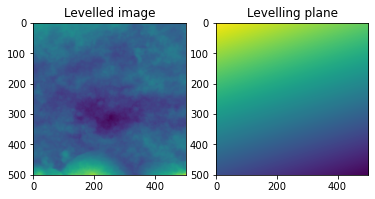

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(plane_level(image))
ax.set_title('Levelled image')
ax = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(plane_level(image, return_form = True))
ax.set_title('Levelling plane')

In [ ]:
image_f = remove_form(plane_level(image))
image_form = remove_form(plane_level(image), return_form = True)

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(image_f)
ax.set_title('Formless Image')
ax = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(image_form)
ax.set_title('Polynomial')

In order to level our data we just:

Similarly, it is recommended to remove noise and attenuate high frequency features. We achieve this through the use of a gaussian filter. 

In [ ]:
#| export
def smooth_image(array, #Numpy array or array like
                 sigma = 1, #Standard deviation for gaussian kernel Useful for determining the wavelength of the low pass filter
                 **kwargs #Keyword arguments for modification of the gaussian_filter function
                ):
    '''
    Removes low frequency/wavelength features ('noise') by applying a gaussian filter on the image. 
    Thin wrapper of scipy.ndimage.gaussian_filter.
    '''
    return ndimage.gaussian_filter(input = array, sigma = sigma, **kwargs)

In [ ]:
image_f_s = smooth_image(image_f,sigma = 1)

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(image_f_s)
ax.set_title('Sigma = 1')
ax = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(smooth_image(image_f, sigma = 10))
ax.set_title('Sigma = 10')

In [ ]:
#| export
def gen_sections(image, #2D array (or arraylike) of height values
                how = 'square', #How to subdivide the array, options are: 'square', 'row', 'column'
                number = 100, #Number of sections to produce
                
                ):
    '''
    Generates sections of the array/image, either in square, horizontal, or vertical sections.
    Useful for studying the change of parameters over the surface.
    Mostly wraps around np.hsplit and np.vsplit.
    Note, if 'number' does not divide into the array evenly, the bottom/side remains will not be
    included. 
    '''
    if how not in ['square','row','column']:
        raise ValueError('Invalid how, expected one of:')
   
    if how == 'square':
        row, col = image.shape
        length   = number**0.5
        roww     = int(row//length)
        colw     = int(col//length) 
        
        sections = []
        for i in range(0, row - (row % roww), roww): #TODO: speed this up 
            for j in range(0, col - (col % colw), colw):
                sections.append(image[i:i+roww,j:j+colw])
        return np.array(sections)
    if how == 'row':
        return np.vsplit(image, number)
    
    if how == 'column':
        return np.hsplit(image, number)

In [ ]:
square = np.arange(0,36).reshape(6,6)
square.size

In [ ]:
square

In [ ]:
rowsec = np.array(gen_sections(square,how = 'row', number = 3))
#np.hsplit(rowsec,3)


In [ ]:
image_sections =  gen_sections(image)

Now, because we've applied all of our preprocessing steps to the original image. We can export it for use later.
We should also save our profiles and sections. The sections should be in .npy format because they are 3D.

In [ ]:
np.savetxt('example.txt', image_f_s)
np.savetxt('example_profiles.txt', gen_rot_prof(image_f_s))
np.save('example_sections.npy', image_sections)

And we can load them back in just to check.

In [ ]:
profiles = np.loadtxt('example_profiles.txt')
plt.imshow(profiles)
plt.show()

In [ ]:
#| hide
from nbdev import nbdev_export
nbdev_export()